In [1]:
using Pkg
Pkg.activate("../Project.toml")
Pkg.instantiate()

  Activating project at `~/Documents/GitHub/Drift_FeedForward`


In [2]:
#45s
#using Distributed
using Dates
using Plots
using JLD2
using LsqFit, StatsBase
using QuadGK
using Parameters
using Distributions
using SpecialFunctions
using Random
using SparseArrays


include(joinpath(@__DIR__,"..","src","Parameter_Setting.jl"))
include(joinpath(@__DIR__,"..","src","Dynamics.jl"))
include(joinpath(@__DIR__,"..","src","reversal_learning.jl"))
include(joinpath(@__DIR__,"..","src","Babadi_Formula.jl"))
include(joinpath(@__DIR__,"..","src","Plot.jl"))

cent(X) = X .- mean(X,dims=1)
corr(X,N) = ((X' * X) / N) ./ sqrt.(diag(X'*X/N) * diag(X' * X/N)')
cov(X,N) = ((X' * X) / N)# ./ sqrt.(diag(X'*X/N) * diag(X' * X/N)')
palette_J = cgrad(:Blues,6,categorical=true)
palette_h = cgrad(:Oranges,6,categorical=true)
tmp_correlation_ϕ(y,ρ,f) = (1/2π) * quadgk(x -> (ϕ(x - Tf(f)) - f)*(ϕ(ρ*x + sqrt(1-ρ^2)*y-Tf(f))-f) * exp(-(x^2+y^2)/2), -5,5)[1]
correlation_ϕ(ρ,f) =  quadgk(y -> tmp_correlation_ϕ(y,ρ,f), -5,5)[1]/(f*(1-f))

correlation_ϕ (generic function with 1 method)

### Fig. 1

In [3]:
#20s
p.P = 1
p.Ns = 100
p.Nc = 1000
p.K = 100

p.γh = 0.
p.σh = 0.
p.γJ = 1.
p.σJ = 1.
#p.σlogJ = 1.

ϕ(x) = x > 0 ? 1 : 0
p.f = 0.1
p.dt = 0.1
p.t_end = 3.
p.model = :dense_normal


Random.seed!(0)
S = (rand(p.Ns,p.P) .> 0.5) * sqrt(2);

In [4]:
#30s You can skip here and use pre-computed data
Random.seed!(0)
for only_responsive in [false,true]
    p.γh = 1.; p.σh = 0.;
    p.γJ = 1.; p.σJ = 1.;
    result_J = simulation_sample_trajectory(p,ϕ,S,true,only_responsive = only_responsive,N_ensemble = 100);

    p.γh = 1.; p.σh = 1.;
    p.γJ = 1.; p.σJ = 0.;
    result_h = simulation_sample_trajectory(p,ϕ,S,true,only_responsive = only_responsive,N_ensemble = 100);
    jldsave("../data/correlation_basic_$(only_responsive).jld2";result_J,result_h)
end

325
373
324
374


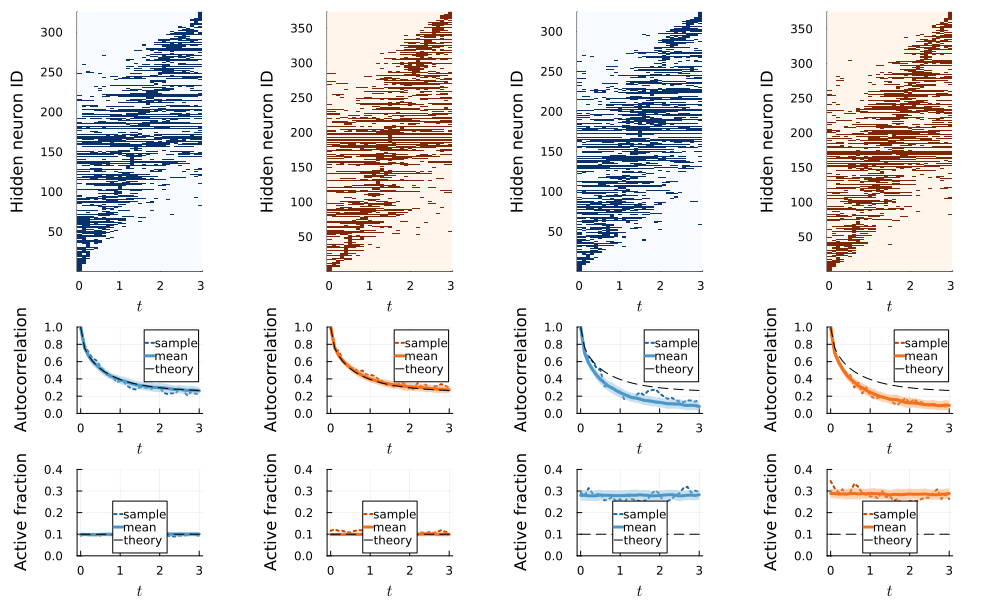

In [17]:
#5s 
#Left/right panels show statistics before/after removing non-responsive neurons.
plots = Vector{Any}(undef, 2)
i_plot = 1
for only_responsive in [false,true]
    jld2data = load("../data/correlation_basic_$(only_responsive).jld2")
    result_J = jld2data["result_J"]
    result_h = jld2data["result_h"];

    plot_result_J = plot_sample_trajectory(p,ϕ,:Blues,result_J,only_responsive = true,ylim_active_fraction = (0,0.4),legend_active_fraction = :bottom);
    #plot_result_J_ = plot!(plot_title="synaptic fluctuation")

    plot_result_h = plot_sample_trajectory(p,ϕ,:Oranges,result_h,only_responsive = true,ylim_active_fraction = (0,0.4),legend_active_fraction = :bottom);
    #plot_result_h_ = plot!(plot_title="excitability fluctuation")
    plot(plot_result_J,plot_result_h,size=(600,750),left_margin=5Plots.mm,right_margin=10Plots.mm)
    savefig("../figure/sample_trajectory_$(only_responsive).pdf")
    plots[i_plot] = plot!()
    i_plot += 1
end
plot(plots...,size = (1000,600))

In [6]:
#1m20s You can skip here and use pre-computed data
Random.seed!(0)
ϕ(x) = x > 0 ? 1 : 0
γlist = [2. ^x for x in -1:1.]
σlist = [2. ^x for x in -1:1.]

p.γh = 1.; p.σh = 1.;
p.γJ = 1.; p.σJ = 1.;

corr_time_ensemble = Array{Any}(undef,2,length(γlist),length(σlist))
corr_time_ensemble_theory = Array{Any}(undef,2,length(γlist),length(σlist))
for i_Jh = 1:2
    for i_γ in 1:length(γlist), i_σ in 1:length(σlist)
        if (i_γ != 2) & (i_σ != 2) continue end
        p.γJ = γlist[i_γ]; p.γh = γlist[i_γ]
        if i_Jh == 1 p.σJ = σlist[i_σ]; p.σh = 0. end
        if i_Jh == 2 p.σh = σlist[i_σ]; p.σJ = 0. end
        _,_,_,_,corr_time_ensemble[i_Jh,i_γ,i_σ],_,corr_time_ensemble_theory[i_Jh,i_γ,i_σ] = simulation_sample_trajectory(p,ϕ,S,true)
    end
end
jldsave("../data/correlation_parameter.jld2";corr_time_ensemble,corr_time_ensemble_theory)

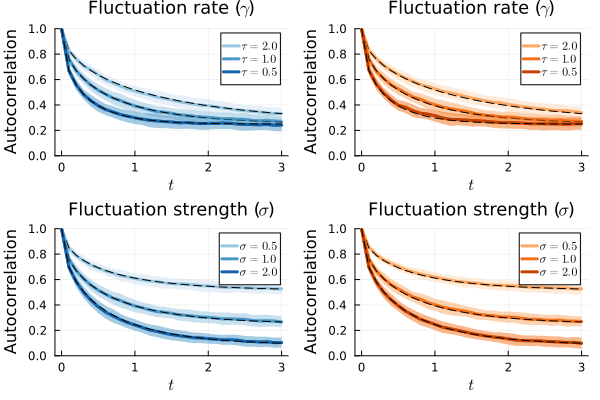

In [12]:
jld2data = load("../data/correlation_parameter.jld2")
corr_time_ensemble = jld2data["corr_time_ensemble"]
corr_time_ensemble_theory = jld2data["corr_time_ensemble_theory"];
γlist = [2. ^x for x in -1:1.]
σlist = [2. ^x for x in -1:1.]

plot_decor_σγ = Array{Any}(undef,2,2)
for i_Jh = 1:2, i_γσ = 1:2
    if i_Jh == 1 palette = cgrad(:Blues,6,categorical=true) end
    if i_Jh == 2 palette = cgrad(:Oranges,6,categorical=true) end
    plot(title = "Fluctuation rate (\$\\gamma\$)",titlefontsize=12); i_σ = 2
    for i_γ = 1:length(γlist)
        p.γJ = γlist[i_γ]; p.γh = γlist[i_γ]
        if i_Jh == 1 p.σJ = σlist[i_σ]; p.σh = 0. end
        if i_Jh == 2 p.σh = σlist[i_σ]; p.σJ = 0. end
        plot_decorrelation!(p,ϕ,palette[i_γ+1],palette[i_γ+2],palette[5],"\$\\tau=$(1/γlist[i_γ])\$", corr_time_ensemble[i_Jh,i_γ,i_σ],corr_time_ensemble_theory[i_Jh,i_γ,i_σ])
    end
    plot_decor_σγ[i_Jh,1] = plot!()
    plot(title = "Fluctuation strength (\$\\sigma\$)",titlefontsize=12); i_γ = 2
    for i_σ = 1:length(σlist)
        p.γJ = γlist[i_γ]; p.γh = γlist[i_γ]
        if i_Jh == 1 p.σJ = σlist[i_σ]; p.σh = 0. end
        if i_Jh == 2 p.σh = σlist[i_σ]; p.σJ = 0. end
        plot_decorrelation!(p,ϕ,palette[i_σ+1],palette[i_σ+2],palette[5],"\$\\sigma=$(σlist[i_σ])\$", corr_time_ensemble[i_Jh,i_γ,i_σ],corr_time_ensemble_theory[i_Jh,i_γ,i_σ])
    end
    plot_decor_σγ[i_Jh,2] = plot!()
end
plot(plot_decor_σγ...,layout=(2,2))
savefig("../figure/time_correlation.pdf")
plot!()

### Fig. S1B

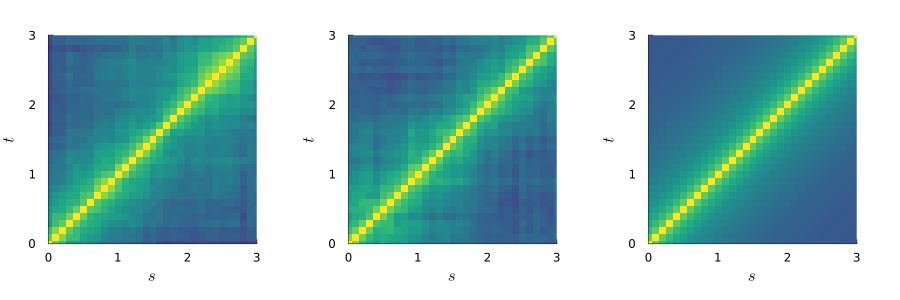

In [13]:
#60s
function heatmap_autocorrelation(corr,colorbar)
    heatmap(
        0:0.1:3,
        0:0.1:3,
        corr,
        aspect_ratio = 1.,
        xlabel = "\$s\$",
        ylabel = "\$t\$",
        xlim = (0,3),
        ylim = (0,3),
        colormap = :viridis,
        clim = (0,1),
        colorbar_ticks = 0:0.5:1,
        colorbar_title = "\n autocorrelation \n between time \$s\$ and \$t\$",
        size = (300,300),
        rightmargin = 5Plots.mm,
        colorbar = colorbar
        )
end
only_responsive = false
jld2data = load("../data/correlation_basic_$(only_responsive).jld2")
result_J = jld2data["result_J"]
result_h = jld2data["result_h"];
tlist = 0:0.1:3
p.γh = 1.; p.γJ = 1.;
p.σh = 1.; p.σJ = 0.;
corr_time_theory = [correlation_ϕ.((1+p.σJ^2*exp(-p.γJ * abs(t-s)) + p.σh^2*exp(-p.γh * abs(t-s)))/(1+p.σJ^2 + p.σh^2),p.f) for t in tlist, s in tlist]
p1 = heatmap_autocorrelation(corr(cent(result_J[2][:,1,:]),p.Nc),false)
p2 = heatmap_autocorrelation(corr(cent(result_h[2][:,1,:]),p.Nc),false)
p3 = heatmap_autocorrelation(corr_time_theory,false)
pcb = heatmap_autocorrelation(corr_time_theory,true)
plot(pcb,rightmargin = 10Plots.mm)
savefig("../figure/heatmap_autocorrelation_cb.pdf")
plot(p1,p2,p3,size = (900,300),layout = (1,3),leftmargin = 3Plots.mm)
savefig("../figure/heatmap_autocorrelation.pdf")
plot!()